# Vorhersage des Ödometerversuches implementiert mit PINA
Ziel war die Implementierung eines neuronalen Netzwerks zur Modellierung des Ödometerversuchs. Dabei wurden gegebene Input-Parameter verarbeitet, um Output-Parameter vorherzusagen. Die physikalischen Rahmenbedingungen wurden zunächst auf Null gesetzt, sodass das Modell ausschließlich auf der KI-basierten Struktur arbeitet, ohne physikalische Optimierungen durch Physical Informed Neural Networks (PINNs).
<br>
Diese grundlegende Umsetzung bildet die Basis für weiterführende Optimierungen, wie die Integration physikalischer Gesetzmäßigkeiten, die jedoch nicht Teil des initialen Arbeitsauftrags waren.

### Was ist PINA?
PINA ist eine Open-Source-Python-Bibliothek, die eine intuitive Schnittstelle zur Lösung von Differentialgleichungen bietet, indem sie Physik-informierte Neuronale Netze (PINNs), Neuronale Operatoren (NOs) oder eine Kombination aus beiden verwendet. Basierend auf PyTorch und PyTorch Lightning ermöglicht PINA die formale Darstellung spezifischer (differentieller) Probleme und deren Lösung mittels neuronaler Netze.<br><br>
<strong>Hauptmerkmale von PINA:</strong>

- <span style="color:gray;"><i>Problemformulierung: Ermöglicht die Übersetzung mathematischer Gleichungen in Python-Code, um das Differentialproblem zu definieren.</i></span>
    - <small><i>→ In diesem Arbeitsauftrag nicht notwendig, da das neuronale Netzwerk ohne physikalische Gesetzmäßigkeiten trainiert wurde.</i></small>
- Modelltraining: Bietet Werkzeuge zum Training neuronaler Netze zur Lösung des definierten Problems.
- Lösungsauswertung: Erlaubt die Visualisierung und Analyse der approximierten Lösungen.

<small><i>Hinweis: Die physikalische Modellierung und die Einbindung von Differentialgleichungen zur Optimierung des Netzwerks (z. B. mittels PINNs) war nicht Teil dieses Arbeitsauftrags, könnte aber in einem späteren Schritt ergänzt werden.</i></small>
## Grundlagen
In diesem Notebook wird der Ödometerversuch <strong>ohne</strong> Randbedingungen betrachtet. Es werden vorberechnetet Daten aus der Exceltabelle `files/oedometer/oedo_trainingsdata.xlsx` verwendet.<br>
#### Das Problem ist wie folgt definiert:
$$
\begin{array}{rcl}
    \sigma_{t+1} & = & \sigma_{t}+\Delta\sigma \\ \\
    \Delta\sigma & = & E_s\cdot \Delta\epsilon \\ 
    E_s & = & \frac{1+e_0}{C_c} \cdot \sigma
\end{array}
\hspace{2cm}
\begin{array}{l}
    \textbf{Annahmen:} \\ \\
    \text{Startwert d. Iteration: } \sigma_0 = 1,00 \\ 
    e_0 = 1,00 \\ 
    C_c = 0,0005
\end{array}
$$

<div = style="text-align: center;">
    <img alt="Problem Oedometer Preview" src="./files/oedometer/problem_preview.png" width="50%" height=auto>
</div>

<br> 

Um das PINA-Model zu testen werden wir folgende vorberechnete Werte verwenden: `Input` {$\sigma_t$, $\Delta\epsilon$}; `Output` {$\sigma_{t+1}$}.

## Einstellungen

In [1]:
import ipywidgets as widgets
from IPython.display import display

# Checkbox erstellen
debug_mode = widgets.Checkbox(
    value=True,  # Standard: Ausgeschaltet
    description="Debug Mode aktivieren",
    disabled=False
)

normalize_data = widgets.Checkbox(
    value=False,  # Standard: Ausgeschaltet
    description="Daten normalisieren",
    disabled=False
)

# Checkbox anzeigen
display(debug_mode)
display(normalize_data)


Checkbox(value=True, description='Debug Mode aktivieren')

Checkbox(value=False, description='Daten normalisieren')

In [2]:
import pandas as pd
import numpy as np
from sympy.integrals.heurisch import components

# Excel-Datei laden (ersetze 'datei.xlsx' mit deinem Dateinamen)
file_path = "files/oedometer/oedo_trainingsdata.xlsx"
sheet_name = "Res"

# Excel-Datei mit explizitem Tabellenblatt laden
df = pd.read_excel(file_path, sheet_name=sheet_name)

# Dynamische Ermittlung der letzten Zeile mit Daten
row_start_range = 0  # Startet bei Zeile 6 (0-basiert)
row_end_range = df.dropna(how="all").last_valid_index() + 1  # Letzte Zeile mit Daten

# Spaltenauswahl Spalte B, D und E
selected_columns = [1, 3, 5]  # Spalten-Indices

# Daten extrahieren
data_subset = df.iloc[row_start_range:row_end_range, selected_columns]

data_dict = {col: np.array(data_subset[col]) for col in data_subset.columns}

if debug_mode.value:
    print('‼️Geladene Exceldaten')
    print(data_dict)

‼️Geladene Exceldaten
{'sigma_0': array([1.00000000e+00, 1.20000000e+00, 1.44000000e+00, 1.72800000e+00,
       2.07360000e+00, 2.48832000e+00, 2.98598400e+00, 3.58318080e+00,
       4.29981696e+00, 5.15978035e+00, 6.19173642e+00, 7.43008371e+00,
       8.91610045e+00, 1.06993205e+01, 1.28391846e+01, 1.54070216e+01,
       1.84884259e+01, 2.21861111e+01, 2.66233333e+01, 3.19479999e+01,
       3.83375999e+01, 4.60051199e+01, 5.52061439e+01, 6.62473727e+01,
       7.94968472e+01, 9.53962166e+01, 1.14475460e+02, 1.37370552e+02,
       1.64844662e+02, 1.97813595e+02, 2.37376314e+02, 2.84851577e+02,
       3.41821892e+02, 4.10186270e+02, 4.92223524e+02, 5.90668229e+02,
       7.08801875e+02, 8.50562250e+02, 1.02067470e+03, 1.22480964e+03,
       1.46977157e+03, 1.76372588e+03, 2.11647106e+03, 2.53976527e+03,
       3.04771832e+03, 3.65726199e+03, 4.38871439e+03, 5.26645726e+03,
       6.31974872e+03, 7.58369846e+03, 9.10043815e+03, 1.09205258e+04,
       1.31046309e+04, 1.57255571e+04, 1.88

<link rel="stylesheet" href="https://cdnjs.cloudflare.com/ajax/libs/font-awesome/4.7.0/css/font-awesome.min.css">

## Daten normalisieren
Die Normalisierung von Daten für neuronale Netze bedeutet, dass Eingabedaten auf eine vergleichbare Skala gebracht werden, um das Training stabiler und effizienter zu machen. Hier verwendete Methode:
- Min-Max-Skalierung: Werte auf einen Bereich (0 bis 1) bringen.  <i class="fa fa-info"> [Wiki](https://en.wikipedia.org/wiki/Feature_scaling#Methods)</i>


In [3]:
if normalize_data.value:
    data_dict.update({'sigma_0_raw': data_dict.pop('sigma_0')})
    data_dict.update({'sigma_1_raw': data_dict.pop('sigma_1')})
    
    sigma_0_min, sigma_0_max = data_dict['sigma_0_raw'].min(), data_dict['sigma_0_raw'].max()
    sigma_1_min, sigma_1_max = data_dict['sigma_1_raw'].min(), data_dict['sigma_1_raw'].max()
    
    # Min-Max-Normalisierung
    data_dict['sigma_0'] = (data_dict['sigma_0_raw'] - sigma_0_min) / (sigma_0_max - sigma_0_min)
    data_dict['sigma_1'] = (data_dict['sigma_1_raw'] - sigma_1_min) / (sigma_1_max - sigma_1_min)
    print('‼️Tabellenwerte des Oedometerversuches normalisiert.')
else:
    print('‼️ Es wurde keine Normalisierung der Werte vorgenommen.')

‼️ Es wurde keine Normalisierung der Werte vorgenommen.


## Konvertierung zu LabelTensor

In [4]:
import torch
from pina.utils import LabelTensor
from torch import tensor

# Beispiel-Daten
sigma_0_train = LabelTensor(tensor(data_dict['sigma_0'], dtype=torch.float).unsqueeze(-1), ['sigma_0'])
delta_epsilon_train = LabelTensor(tensor(data_dict['delta_epsilon'], dtype=torch.float).unsqueeze(-1), ['delta_epsilon'])
sigma_1_train = LabelTensor(tensor(data_dict['sigma_1'], dtype=torch.float).unsqueeze(-1), ['sigma_1'])

# Kombinieren der Trainingsdaten
input_points_combined = LabelTensor(torch.tensor(np.column_stack([data_dict['sigma_0'], data_dict['delta_epsilon']]), dtype=torch.float), ['sigma_0', 'delta_epsilon'])

if debug_mode.value:
    print('‼️Data Loaded')
    print(f' sigma_0: {sigma_0_train.size()}')
    print(f' delta_epsilon: {delta_epsilon_train.shape}')
    print(f' sigma_0 und delta_epsilon combined: {input_points_combined.size()}')
    print(f' sigma_1: {sigma_1_train.shape}')


‼️Data Loaded
 sigma_0: torch.Size([94, 1])
 delta_epsilon: torch.Size([94, 1])
 sigma_0 und delta_epsilon combined: torch.Size([94, 2])
 sigma_1: torch.Size([94, 1])


## Problemdefinition

### Hinweise
- Input und Output Werte müssen aus der Excel als Condition übergeben werden.
- Auch wenn die `domain` nicht verwendet wird, muss diese definiert sein und darf nicht leer sein! Generell ist dieses Attribut notwendig um den Wertebereich für die Datengenerierung zu bestimmen.
  - Siehe Kommentar `problem.discretise_domain`. 

In [5]:
from pina.problem import AbstractProblem
from pina.geometry import CartesianDomain
from pina import Condition
class SimpleODE(AbstractProblem):

    # Definition der Eingabe- und Ausgabevariablen basierend auf LabelTensor
    input_variables = input_points_combined.labels
    output_variables = sigma_1_train.labels

    # Wertebereich
    domain = CartesianDomain({'sigma_0': [0, 1], 'delta_epsilon': [0, 1]})  # Wertebereich immer definieren!

    # Definition der Randbedingungen und vorberechnetet Punkte
    conditions = {
        'data': Condition(input_points=input_points_combined, output_points=sigma_1_train),
    }

    output_pts=sigma_1_train

    # Methode zur Definition der "wahren Lösung" des Problems
    def truth_solution(self, pts):
        return torch.exp(pts.extract(['sigma_0']))

# Problem-Instanz erzeugen
problem = SimpleODE()

# Datengenerierung, falls Randbedingungen definiert
# problem.discretise_domain(n=993, mode='random', variables='all', locations='all') # Notwendig, wenn "input_pts" und "output_pts" nicht vorgegeben sind

if debug_mode.value:
    # Debugging-Ausgaben
    print("‼️Geladene Input Variablen: ", problem.input_variables)
    print("‼️Geladene Output Variablen: ", problem.output_variables)
    print('‼️Input points:', problem.input_pts)

‼️Geladene Input Variablen:  ['sigma_0', 'delta_epsilon']
‼️Geladene Output Variablen:  ['sigma_1']
‼️Input points: {'data': LabelTensor([[[1.0000e+00, 5.0000e-04]],
             [[1.2000e+00, 5.0000e-04]],
             [[1.4400e+00, 5.0000e-04]],
             [[1.7280e+00, 5.0000e-04]],
             [[2.0736e+00, 5.0000e-04]],
             [[2.4883e+00, 5.0000e-04]],
             [[2.9860e+00, 5.0000e-04]],
             [[3.5832e+00, 5.0000e-04]],
             [[4.2998e+00, 5.0000e-04]],
             [[5.1598e+00, 5.0000e-04]],
             [[6.1917e+00, 5.0000e-04]],
             [[7.4301e+00, 5.0000e-04]],
             [[8.9161e+00, 5.0000e-04]],
             [[1.0699e+01, 5.0000e-04]],
             [[1.2839e+01, 5.0000e-04]],
             [[1.5407e+01, 5.0000e-04]],
             [[1.8488e+01, 5.0000e-04]],
             [[2.2186e+01, 5.0000e-04]],
             [[2.6623e+01, 5.0000e-04]],
             [[3.1948e+01, 5.0000e-04]],
             [[3.8338e+01, 5.0000e-04]],
             [

## Visualisierung Sampling
Darstellung Input: `sigma_0` und `delta_epsilon`

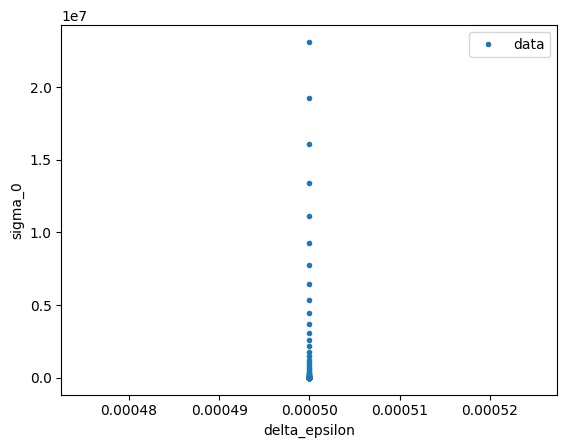

In [6]:
from pina import Plotter

pl = Plotter()
pl.plot_samples(problem=problem, variables=['delta_epsilon','sigma_0'])

In [8]:
from pina import Trainer
from pina.solvers import PINN
from pina.model import FeedForward
from pina.callbacks import MetricTracker
import torch
from pytorch_lightning.loggers import TensorBoardLogger  # Import TensorBoard Logger

if debug_mode.value:
    # Überprüfen der Größe der Eingabepunkte und Ausgabepunkte
    print("‼️Länge der Eingabepunkte (input_pts):", len(problem.input_pts['data']))
    print("‼️Länge der Ausgabepunkte (output_pts):", len(problem.output_pts))

# Model erstellen
model = FeedForward(
    layers=[50, 50, 50],
    func=torch.nn.ReLU,
    output_dimensions=len(problem.output_variables),
    input_dimensions=len(problem.input_variables)
)

# PINN-Objekt erstellen
pinn = PINN(problem, model)

# TensorBoard-Logger einrichten
logger = TensorBoardLogger("tensorboard_logs", name="pina_experiment")

# Trainer erstellen mit TensorBoard-Logger
trainer = Trainer(
    solver=pinn,
    max_epochs=1500,
    callbacks=[MetricTracker()],
    batch_size=10,
    accelerator='cpu',
    logger=logger,
    enable_model_summary=False,
)


# Training starten
trainer.train()

# Inspect final loss
trainer.logged_metrics


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


‼️Länge der Eingabepunkte (input_pts): 94
‼️Länge der Ausgabepunkte (output_pts): 94


C:\Users\hab185\Documents\00_Tim\01_Implementierung\pina_oedometer\venv\Lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (10) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |                                                                    | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1500` reached.


{'data_loss': tensor(0.0019), 'mean_loss': tensor(0.0019)}

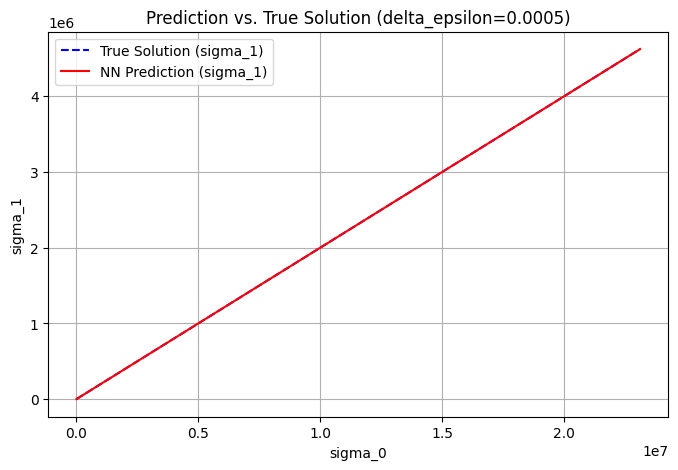

In [9]:
import matplotlib.pyplot as plt
import torch

# Erstelle die Eingabedaten als LabelTensor für das trainierte Modell
input_data = LabelTensor(torch.tensor(
    np.column_stack((data_dict['sigma_0'], data_dict['delta_epsilon'])), dtype=torch.float
), ['sigma_0', 'delta_epsilon'])

# Model-Vorhersage für sigma_1 berechnen
sigma_1_pred = pinn(input_data).detach().numpy()

# Plot der wahren vs. vorhergesagten Werte
plt.figure(figsize=(8, 5))

plt.plot(data_dict['sigma_0'], data_dict['sigma_1'], label="True Solution (sigma_1)", linestyle='dashed', color='blue')
plt.plot(data_dict['sigma_0'], sigma_1_pred, label="NN Prediction (sigma_1)", linestyle='solid', color='red')

plt.xlabel("sigma_0")
plt.ylabel("sigma_1")
plt.title("Prediction vs. True Solution (delta_epsilon=0.0005)")
plt.legend()
plt.grid()
plt.show()


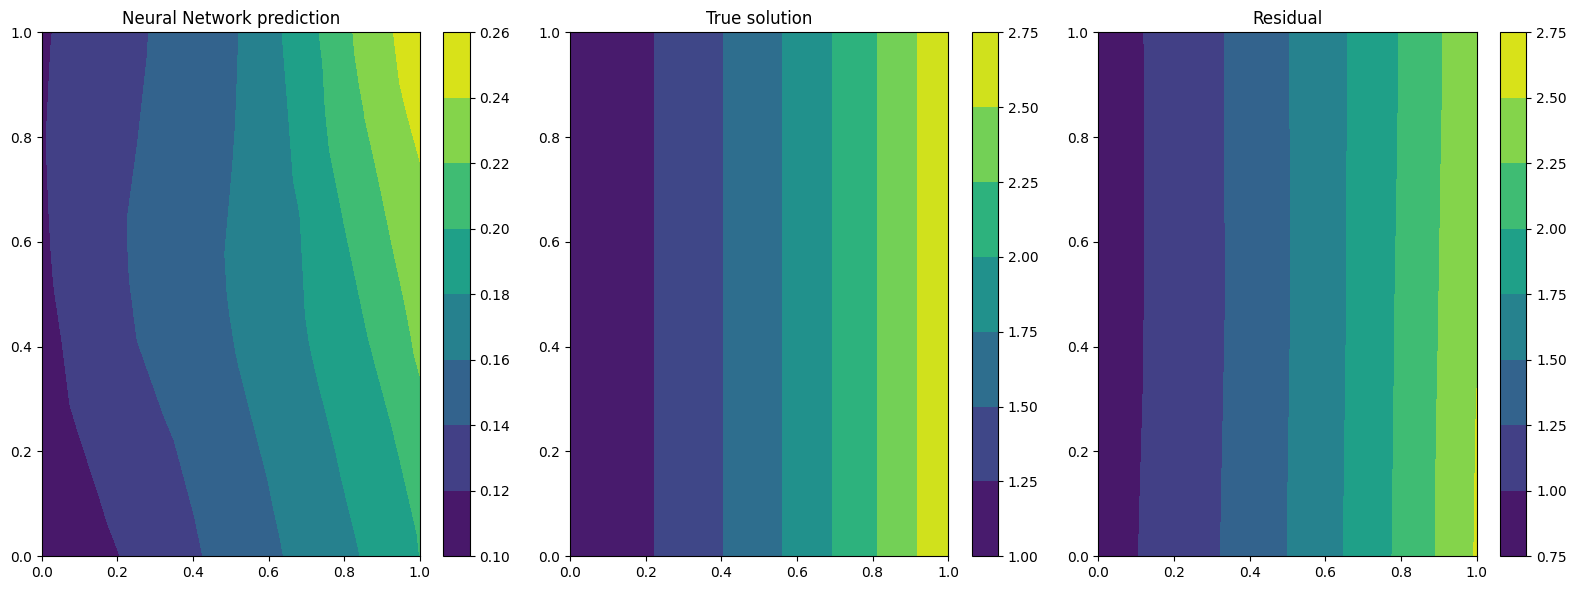

In [10]:
pl.plot(solver=pinn)

## Visualisierung Loss-Kurve


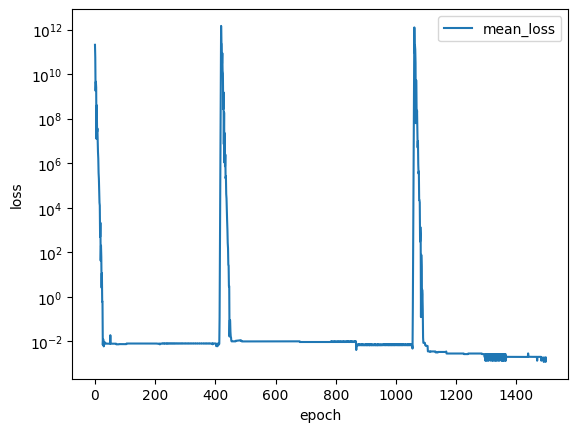

In [11]:
# plotting the solution
pl.plot_loss(trainer, label='mean_loss', logy=True)